In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D, Dropout, ReLU, Add, BatchNormalization, Multiply, GlobalAveragePooling2D, Reshape,DepthwiseConv2D
from keras.optimizers import RMSprop
import keras.backend as K
import cv2
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from PIL import Image
from tensorflow.keras.metrics import Metric,Precision, Recall
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from sklearn.metrics import auc,confusion_matrix,precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
#from keras.utils.vis_utils import plot_model
import pandas as pd
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
import seaborn as sns


2023-12-14 02:33:46.654603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 02:33:47.962995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# train_dir = r'E:\MV\coursework\fruits-360\Training'
# test_dir = r'E:\MV\coursework\fruits-360\Test'
train_dir = r'/home/featurize/data/Training'
test_dir = r'/home/featurize/data/Test'
#The total number of images: 90483.
#Training set size: 67692 images (one fruit or vegetable per image).
#Test set size: 22688 images (one fruit or vegetable per image).
#The number of classes: 131 (fruits and vegetables).
#Image size: 100x100 pixels.

In [3]:
#find out the total calsses of dataset.
className = glob.glob(train_dir + "/*")
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  131


In [4]:
def denoise_background(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    np.copyto(image, thresh_rgb, where=thresh_rgb == 255)
    return image

In [5]:
# Load and preprocess the training data
train_datagen = ImageDataGenerator(
    preprocessing_function=denoise_background,
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.068,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='training' 
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100,100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='validation'
)

# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 63145 images belonging to 131 classes.
Found 4547 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
input_shape = Input(shape=(100,100,3))

In [7]:
class CustomAccuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)
        correct_predictions = tf.equal(y_pred_classes, y_true_classes)
        correct_predictions = tf.cast(correct_predictions, 'float32')
        
        self.correct.assign_add(tf.reduce_sum(correct_predictions))
        self.total.assign_add(tf.cast(tf.size(y_true_classes), 'float32'))

    def result(self):
        return tf.divide(self.correct, self.total)

    def reset_state(self):
        self.correct.assign(0)
        self.total.assign(0)


In [8]:
class CustomCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, name='loss', **kwargs):
        super(CustomCrossEntropyLoss, self).__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        epsilon = 1e-10
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

        return loss

Model 1: 3 inception block +SE  

Model2: 4 res_block+DepthwiseConv+SE

In [9]:
def se_block(input_tensor, ratio=16):
# Squeeze-and-Excitation block
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    scaled_input = Multiply()([input_tensor, se])
    return scaled_input

def inception_block(x, br1, br2_1, br2_2, br3_1, br3_2, br4):
    # Branch 1
    branch1 = Conv2D(br1, (1, 1), padding='same', activation='relu')(x)
    # Branch 2 3x3-> 1x3 3x1
    branch2 = Conv2D(br2_1, (1, 1), padding='same', activation='relu')(x)
    #branch2 = Conv2D(br2_2, (3, 3), padding='same', activation='relu')(branch2)
    branch2 = Conv2D(br2_2, (1, 3), padding='same', activation='relu')(branch2)
    branch2 = Conv2D(br2_2, (3, 1), padding='same', activation='relu')(branch2)
    # Branch 3 5x5->3x3 3x3-> 1x3 3x1 1x3 3x1 
    branch3 = Conv2D(br3_1, (1, 1), padding='same', activation='relu')(x)
    #branch3 = Conv2D(br3_2, (5, 5), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (1, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (3, 1), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (1, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (3, 1), padding='same', activation='relu')(branch3)
    # Branch 4
    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(br4, (1, 1), padding='same', activation='relu')(branch4)
    # Concatenate all the branches
    branch_output = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    # After the Inception block, apply the SE block
    branch_output = se_block(branch_output)
    return branch_output

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_shape)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 64, 96, 64, 16, 32, 32)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 128, 128, 128, 32, 64, 64)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 160, 160, 160, 48, 96, 96)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
# Final layers
x = GlobalAveragePooling2D()(x)
output = Dense(numberOfClass, activation='softmax')(x)
model_1 = Model(inputs=input_shape, outputs=output)

def res_block(input_tensor, filters, strides=1):
    shortcut = input_tensor

    # First component of main path
    x = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second component of main path
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)
    x = Conv2D(filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third component of main path
    x = Conv2D(filters * 4, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = se_block(x)

    # Shortcut path
    if strides != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Final step: Add shortcut value to main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def combined_model():

    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(2,2)(x)

    x = res_block(x, filters=64, strides=1)
    x = res_block(x, filters=128, strides=2)
    x = res_block(x, filters=256, strides=2)
    x = res_block(x, filters=512, strides=2)
    x = MaxPooling2D(2,2)(x)

    x = GlobalAveragePooling2D()(x)
    output = Dense(numberOfClass, activation='softmax')(x)

    model_2 = Model(inputs=input_shape, outputs=output)
    concatenated_output= concatenate([model_1.output, model_2.output])

    x = Dense(128, activation='relu')(concatenated_output) 
    x = BatchNormalization()(x) 
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Dropout(0.3)(x)
    ensemble_output= Dense(numberOfClass, activation='softmax')(x)
    #Build the ensemble model
    combined_model = Model(inputs=input_shape, outputs= ensemble_output)
    return combined_model

2023-12-14 02:33:54.570727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 02:33:54.595198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 02:33:54.595439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Add the output layer for the other models

In [10]:
def add_new_last_layer(base_model):
    x = Dense(128, activation='relu')(base_model.output) 
    x = BatchNormalization()(x) 
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Dropout(0.3)(x)
    last_output= Dense(numberOfClass, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=last_output)
    return model 

def prepare_model(model):
    model = add_new_last_layer(model)
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy(), Precision(name='precision'),Recall(name='recall')])
    return model

Compile the models

In [11]:
combined_model=combined_model()
#Build the ensemble model
combined_model.compile(optimizer='RMSprop', loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy(), Precision(name='precision'),Recall(name='recall')])

In [12]:
vgg16_model = prepare_model(VGG16(weights=None, include_top=False, input_shape=(100,100,3)))
resnet50_model = prepare_model(ResNet50(weights=None, include_top=False, input_shape=(100,100,3)))
inceptionv3_model = prepare_model(InceptionV3(weights=None, include_top=False, input_shape=(100,100,3)))
mobilenet_model = prepare_model(MobileNet(weights=None, include_top=False, input_shape=(100,100,3)))


Load the training history of combined_model

In [13]:
history_combined = pd.read_csv("/home/featurize/data/premodel_history_weights/combined_model_40epoch_1211.csv")
history_resnet50 = pd.read_csv("/home/featurize/data/premodel_history_weights/resnet50_model_training_history_40epoch_1211.csv")
history_inceptionv3 = pd.read_csv("/home/featurize/data/premodel_history_weights/inceptionv3_model_training_history_40epoch_1211.csv")
history_mobilenet = pd.read_csv("/home/featurize/data/premodel_history_weights/resnet50_model_training_history_40epoch_1211.csv")
history_vgg16 = pd.read_csv("/home/featurize/data/premodel_history_weights/vgg16_model_training_history_40epoch_1211.csv")


Load the trained models

In [14]:
load_path1=r'/home/featurize/data/premodel_history_weights/combined_model1211_40epochs.h5'
combined_model=tf.keras.models.load_model(load_path1,custom_objects={'CustomAccuracy':CustomAccuracy(),'CustomCrossEntropyLoss':CustomCrossEntropyLoss()})
load_path2=r'/home/featurize/data/premodel_history_weights/vgg16_model1212_40epochs.h5'
vgg16_model=tf.keras.models.load_model(load_path2,custom_objects={'CustomAccuracy':CustomAccuracy(),'CustomCrossEntropyLoss':CustomCrossEntropyLoss()})
load_path3=r'/home/featurize/data/premodel_history_weights/resnet50_model1212_40epochs.h5'
resnet50_model=tf.keras.models.load_model(load_path3,custom_objects={'CustomAccuracy':CustomAccuracy(),'CustomCrossEntropyLoss':CustomCrossEntropyLoss()})
load_path4=r'/home/featurize/data/premodel_history_weights/inceptionv3_model1212_40epochs.h5'
inceptionv3_model=tf.keras.models.load_model(load_path4,custom_objects={'CustomAccuracy':CustomAccuracy(),'CustomCrossEntropyLoss':CustomCrossEntropyLoss()})
load_path5=r'/home/featurize/data/premodel_history_weights/mobilenet_model1213_40epochs.h5'
mobilenet_model=tf.keras.models.load_model(load_path5,custom_objects={'CustomAccuracy':CustomAccuracy(),'CustomCrossEntropyLoss':CustomCrossEntropyLoss()})

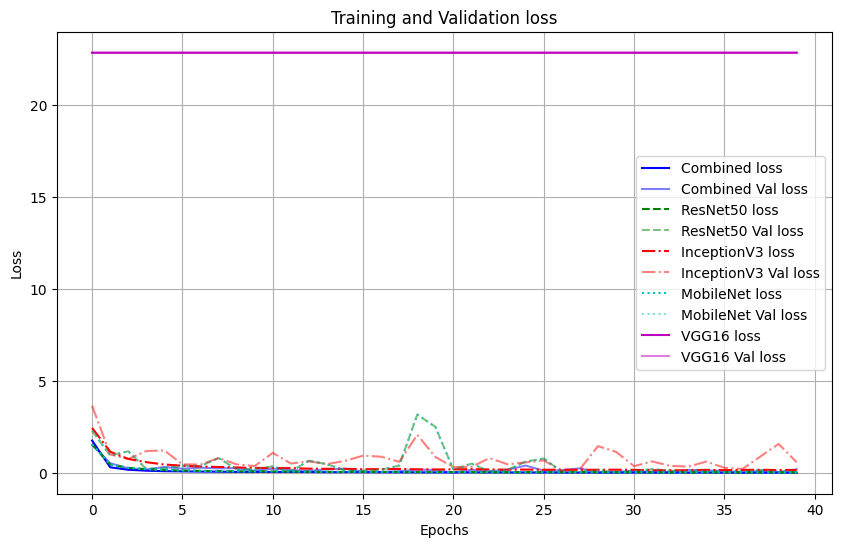

In [15]:
#sotre all the historys
histories = {
    "Combined": history_combined,
    "ResNet50": history_resnet50,
    "InceptionV3": history_inceptionv3,
    "MobileNet": history_mobilenet,
    "VGG16": history_vgg16
}

#define the colour and lines.
colors = ['b', 'g', 'r', 'c', 'm']
line_styles = ['-', '--', '-.', ':', '-']

def plot_metric(metric):
    plt.figure(figsize=(10, 6))
    for (model_name, history), color, line_style in zip(histories.items(), colors, line_styles):
        plt.plot(history[metric], color=color, linestyle=line_style, label=f'{model_name} {metric}')
        plt.plot(history[f'val_{metric}'], color=color, linestyle=line_style, label=f'{model_name} Val {metric}', alpha=0.5)
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

for metric in ['loss', 'accuracy', 'precision', 'recall']:
    plot_metric(metric)

Draw the F1-score plot  during training and validation

In [16]:
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

# drwaw the Fi score
def plot_f1_scores():
    plt.figure(figsize=(10, 6))
    for model_name, history in histories.items():
        #Calculate F1 scores for training and verification.
        train_f1 = calculate_f1(history['precision'], history['recall'])
        val_f1 = calculate_f1(history['val_precision'], history['val_recall'])

        plt.plot(train_f1, label=f'{model_name} Train F1')
        plt.plot(val_f1, '--', label=f'{model_name} Val F1')

    plt.title('Training and Validation F1 Scores')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_scores()

Evaluate all models

In [17]:
loss1, accuracy1, precision1, recall1 = combined_model.evaluate(test_generator)
loss2, accuracy2, precision2, recall2 = resnet50_model.evaluate(test_generator)
loss3, accuracy3, precision3, recall3 = inceptionv3_model.evaluate(test_generator)
loss4, accuracy4, precision4, recall4 = mobilenet_model.evaluate(test_generator)
loss5, accuracy5, precision5, recall5 = vgg16_model.evaluate(test_generator)

2023-12-14 02:34:10.719425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-14 02:34:11.787881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


709/709 [==============================] - 11s 15ms/step - loss: 22.8572 - accuracy: 0.0073 - precision: 0.0073 - recall: 0.0073


Show the evaluation results

In [18]:
model_names = ['Combined Model', 'ResNet50', 'InceptionV3', 'MobileNet', 'VGG16']
loss_values = [loss1, loss2, loss3, loss4, loss5]
accuracy_values = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5]
precision_values = [precision1, precision2, precision3, precision4, precision5]
recall_values = [recall1, recall2, recall3, recall4, recall5]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loss
bars = axes[0, 0].bar(model_names, loss_values, color='blue')
axes[0, 0].set_title('Loss Comaprason Of Different Models')
axes[0, 0].set_ylabel('Loss')
for bar, value in zip(bars, loss_values):
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}', 
                    ha='center', va='bottom')

# Accuracy
bars = axes[0, 1].bar(model_names, accuracy_values, color='green')
axes[0, 1].set_title('Accuracy Comaprason Of Different Models')
axes[0, 1].set_ylabel('Accuracy')
for bar, value in zip(bars, accuracy_values):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}', 
                    ha='center', va='bottom')

# Precision
bars = axes[1, 0].bar(model_names, precision_values, color='orange')
axes[1, 0].set_title('Precision Comaprason Of Different Models')
axes[1, 0].set_ylabel('Precision')
for bar, value in zip(bars, precision_values):
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}', 
                    ha='center', va='bottom')

# Recall
bars = axes[1, 1].bar(model_names, recall_values, color='red')
axes[1, 1].set_title('Recall Comaprason Of Different Models')
axes[1, 1].set_ylabel('Recall')
for bar, value in zip(bars, recall_values):
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}', 
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


F1_score in Test dataset

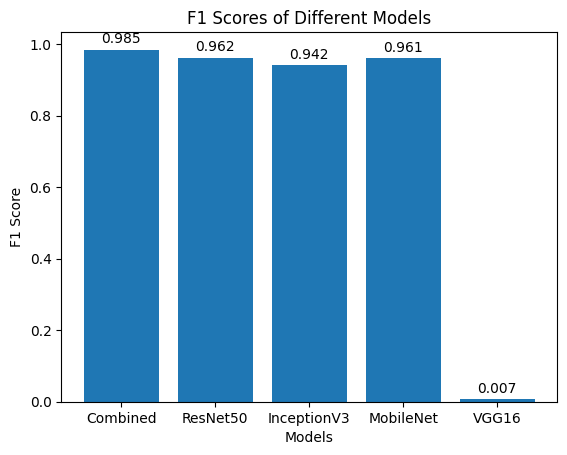

In [19]:
f1_combined = 2 * (precision1 * recall1) / (precision1 + recall1)
f1_resnet50 = 2 * (precision2 * recall2) / (precision2 + recall2)
f1_inceptionv3 = 2 * (precision3 * recall3) / (precision3 + recall3)
f1_mobilenet = 2 * (precision4 * recall4) / (precision4 + recall4)
f1_vgg16 = 2 * (precision5 * recall5) / (precision5 + recall5)

models = ['Combined', 'ResNet50', 'InceptionV3', 'MobileNet', 'VGG16']
f1_scores = [f1_combined, f1_resnet50, f1_inceptionv3, f1_mobilenet, f1_vgg16]

for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

plt.bar(models, f1_scores)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Different Models')
plt.show()



Confusion Matrix

In [20]:
# Collect all the images and labels
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
all_images = np.concatenate(all_images)
all_true_labels = np.concatenate(all_true_labels)

# Predictions for each model
predictions_combined = combined_model.predict(all_images)
predictions_vgg16 = vgg16_model.predict(all_images)
predictions_resnet50 = resnet50_model.predict(all_images)
predictions_inceptionv3 = inceptionv3_model.predict(all_images)
predictions_mobilenet = mobilenet_model.predict(all_images)

# Convert predictions to class labels
predicted_labels_combined = np.argmax(predictions_combined, axis=1)
predicted_labels_vgg16 = np.argmax(predictions_vgg16, axis=1)
predicted_labels_resnet50 = np.argmax(predictions_resnet50, axis=1)
predicted_labels_inceptionv3 = np.argmax(predictions_inceptionv3, axis=1)
predicted_labels_mobilenet = np.argmax(predictions_mobilenet, axis=1)

all_true_labels = np.argmax(all_true_labels, axis=1)


709/709 [==============================] - 4s 5ms/step


In [21]:
# Generate confusion matrices for each model
conf_matrix_combined = confusion_matrix(all_true_labels, predicted_labels_combined)
conf_matrix_vgg16 = confusion_matrix(all_true_labels, predicted_labels_vgg16)
conf_matrix_resnet50 = confusion_matrix(all_true_labels, predicted_labels_resnet50)
conf_matrix_inceptionv3 = confusion_matrix(all_true_labels, predicted_labels_inceptionv3)
conf_matrix_mobilenet = confusion_matrix(all_true_labels, predicted_labels_mobilenet)

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(300, 200))
sns.heatmap(conf_matrix_combined, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(131)], yticklabels=[f"Class {i}" for i in range(131)], ax=axes[0, 0])
axes[0, 1].set_title("Esemble Model")

sns.heatmap(conf_matrix_vgg16, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(131)], yticklabels=[f"Class {i}" for i in range(131)], ax=axes[0, 1])
axes[0, 1].set_title("VGG16 Model")

sns.heatmap(conf_matrix_resnet50, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(131)], yticklabels=[f"Class {i}" for i in range(131)], ax=axes[0, 2])
axes[0, 2].set_title("ResNet50 Model")

sns.heatmap(conf_matrix_inceptionv3, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(131)], yticklabels=[f"Class {i}" for i in range(131)], ax=axes[1, 0])
axes[1, 0].set_title("InceptionV3 Model")

sns.heatmap(conf_matrix_mobilenet, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(131)], yticklabels=[f"Class {i}" for i in range(131)], ax=axes[1, 1])
axes[1, 1].set_title("MobileNet Model")

# Hide the empty subplot
axes[1, 2].axis("off")

plt.suptitle("Confusion Matrices for Multiple Models", fontsize=16)
plt.show()

Calcalate Accuracy, Precision, Recall, Specificity, F1-score, Kappa

In [23]:
def calculate_macro_metrics(conf_matrix):
    num_classes = conf_matrix.shape[0]

    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0

    for k in range(num_classes):
        TP = conf_matrix[k, k]
        FP = conf_matrix[:, k].sum() - TP
        FN = conf_matrix[k, :].sum() - TP
        TN = conf_matrix.sum() - (FP + FN + TP)

        total_TP += TP
        total_FP += FP
        total_FN += FN
        total_TN += TN

    macro_accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN)
    macro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) != 0 else 0
    macro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) != 0 else 0
    macro_sensitivity = macro_recall
    macro_specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) != 0 else 0
    # Calculate F1-score
    macro_f1_score = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) != 0 else 0

    # Kappa
    total_accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN)
    random_accuracy = ((total_TP + total_FP) * (total_TP + total_FN) + (total_FN + total_TN) * (total_FP + total_TN)) / (total_TP + total_FP + total_FN + total_TN)**2
    kappa = (total_accuracy - random_accuracy) / (1 - random_accuracy)

    return {
        'Macro Accuracy': macro_accuracy,
        'Macro Recall': macro_recall,
        'Macro Precision': macro_precision,
        'Macro Sensitivity': macro_sensitivity,
        'Macro Specificity': macro_specificity,
        'Macro f1_score': macro_f1_score,
        'Macro kappa': kappa
    }


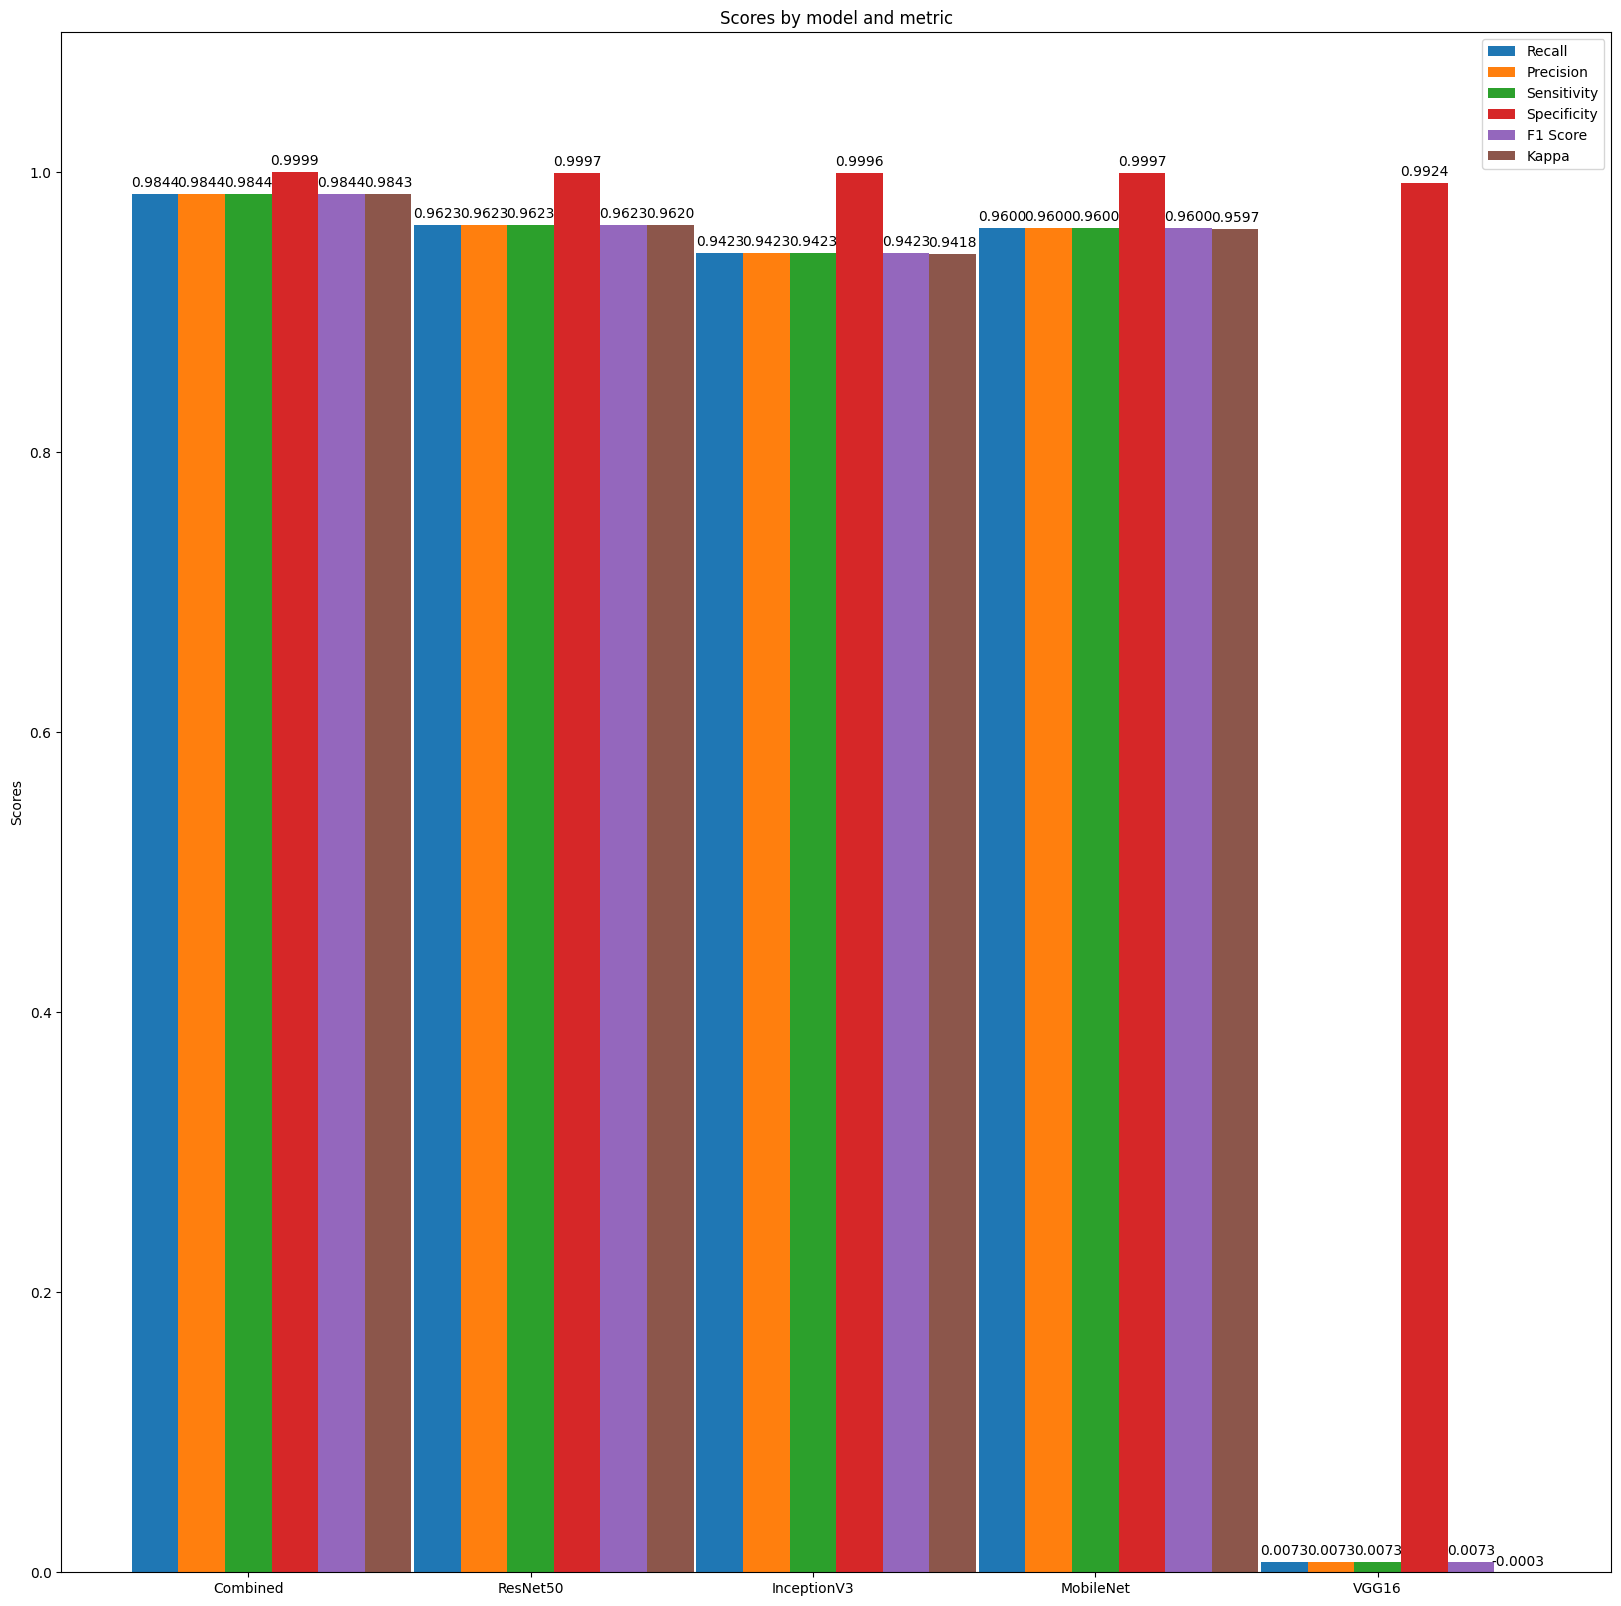

In [27]:
macro_metrics_combined = calculate_macro_metrics(conf_matrix_combined)
macro_metrics_resnet50 = calculate_macro_metrics(conf_matrix_resnet50)
macro_metrics_inceptionv3 = calculate_macro_metrics(conf_matrix_inceptionv3)
macro_metrics_mobilenet = calculate_macro_metrics(conf_matrix_mobilenet)
macro_metrics_vgg16 = calculate_macro_metrics(conf_matrix_vgg16)

models_metrics = {
    'Combined': macro_metrics_combined,
    'ResNet50': macro_metrics_resnet50,
    'InceptionV3': macro_metrics_inceptionv3,
    'MobileNet': macro_metrics_mobilenet,
    'VGG16': macro_metrics_vgg16
}

accuracy = []
recall = []
precision = []
sensitivity = []
specificity = []
f1_score = []
kappa = []

for model in models_metrics.values():
    recall.append(model['Macro Recall'])
    precision.append(model['Macro Precision'])
    sensitivity.append(model['Macro Sensitivity'])
    specificity.append(model['Macro Specificity'])
    f1_score.append(model['Macro f1_score'])
    kappa.append(model['Macro kappa'])

labels = list(models_metrics.keys())
x = np.arange(len(labels)) * 2 
width = 0.33 

fig, ax = plt.subplots(figsize=(20, 20))
rects1 = ax.bar(x - width*2, recall, width, label='Recall')
rects2 = ax.bar(x - width, precision, width, label='Precision')
rects3 = ax.bar(x, sensitivity, width, label='Sensitivity')
rects4 = ax.bar(x + width, specificity, width, label='Specificity')
rects5 = ax.bar(x + width*2, f1_score, width, label='F1 Score')
rects6 = ax.bar(x + width*3, kappa, width, label='Kappa')


def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)
add_labels(rects5)
add_labels(rects6)

ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1)

plt.show()




PR Curve

In [35]:
y_true_binary = label_binarize(all_true_labels, classes=range(131))

model_predictions = {
    'Combined': predictions_combined,
    'VGG16': predictions_vgg16,
    'ResNet50': predictions_resnet50,
    'InceptionV3': predictions_inceptionv3,
    'MobileNet': predictions_mobilenet
}

plt.figure(figsize=(10, 8))

for model_name, predictions in model_predictions.items():
    precision = dict()
    recall = dict()
    for i in range(131):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], predictions[:, i])


        micro_precision, micro_recall, _ = precision_recall_curve(y_true_binary.ravel(), predictions.ravel())
    plt.plot(micro_recall, micro_precision, label='{0} PR curve (area = {1:0.3f})'.format(model_name, auc(micro_recall, micro_precision)))
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision-Recall Curve for different models')
plt.legend(loc='best')
plt.show()


ROC Curve

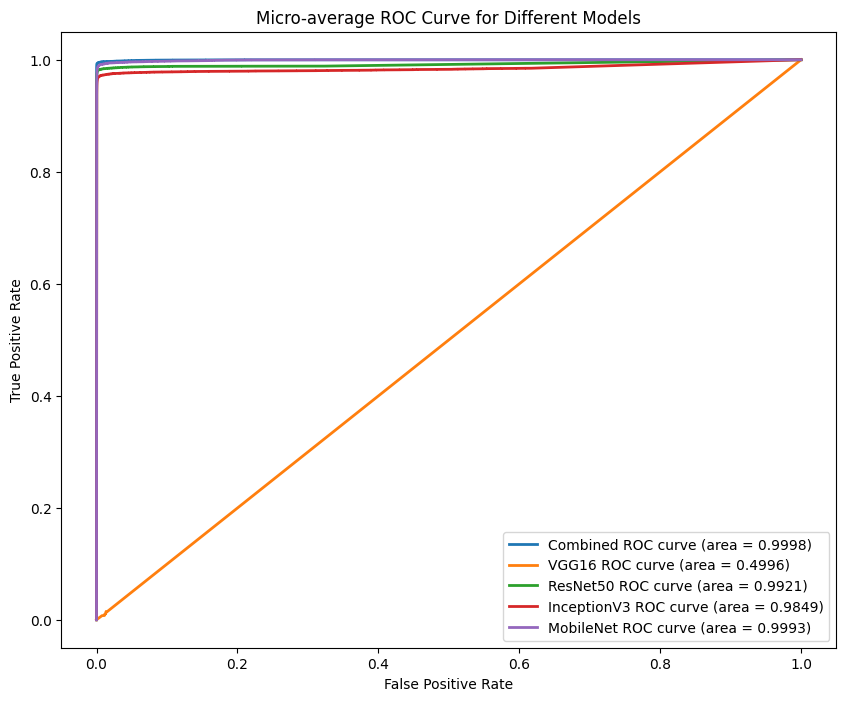

In [39]:

plt.figure(figsize=(10, 8))

for model_name, predictions in model_predictions.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(131):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], predictions[:, i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"], label=f'{model_name} ROC curve (area = {roc_auc["micro"]:0.4f})', linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve for Different Models')
plt.legend(loc="lower right")
plt.show()
